# HYBRID MODEL OPTION 1:

## 1. Preprocessing

In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import numpy as np

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pointbiserialr
from sklearn.metrics import make_scorer, recall_score, confusion_matrix


In [6]:
def preprocess_data(
    file='data/wdbc.data',
    corr_threshold=0.3,
    test_size=0.2,
    random_state=42
):
    # -------------------------------------
    # 1) Load dataset and rename columns
    # -------------------------------------
    df = pd.read_csv(file, header=None)
    cols = ["id", "diagnosis"] + [
        f"{feat}_{stat}"
        for stat in ["mean", "se", "worst"]
        for feat in ["radius", "texture", "perimeter", "area",
                     "smoothness", "compactness", "concavity",
                     "concave_points", "symmetry", "fractal_dimension"]
    ]
    df.columns = cols

    # -------------------------------------
    # 2) Numerical encoding for correlation filtering
    # -------------------------------------
    df["diagnosis"] = df["diagnosis"].map({"B": 0.0, "M": 1.0})

    correlated_columns = ["diagnosis"]
    for col in df.drop(columns=["diagnosis", "id"]).columns:
        r, _ = pointbiserialr(df["diagnosis"], df[col].astype(float))
        if r > corr_threshold:
            correlated_columns.append(col)

    df = df[correlated_columns]

    # Convert back to category labels
    df["diagnosis"] = df["diagnosis"].map({0.0: "Benign", 1.0: "Malignant"}).astype("category")

    # -------------------------------------
    # 3) Split into X and y
    # -------------------------------------
    X = df.drop(columns=["diagnosis"])
    y = df["diagnosis"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # -------------------------------------
    # 4) Scaling
    # -------------------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # -------------------------------------
    # 5) PCA
    # -------------------------------------
    pca = PCA(n_components= 5)
    pca.fit(X_train_scaled)

    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    # -------------------------------------
    # 6) Return everything useful
    # -------------------------------------
    return {
        "df": df,                            
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca
    }


In [13]:
prep_data = preprocess_data()

df = prep_data["df"]
X_train = prep_data["X_train"]
X_test = prep_data["X_test"]
y_train = prep_data["y_train"]
y_test = prep_data["y_test"]
X_train_scaled = prep_data["X_train_scaled"]
X_test_scaled = prep_data["X_test_scaled"]
X_train_pca = prep_data["X_train_pca"]
X_test_pca = prep_data["X_test_pca"]
y_train_numeric = y_train.replace({"Malignant": 1, "Benign": 0}).astype(float)
y_test_numeric  = y_test.replace({"Malignant": 1, "Benign": 0}).astype(float)

/var/folders/gx/8_x0j9wx7kl8gs36bydwh7l00000gr/T/ipykernel_11869/2307572630.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_numeric = y_train.replace({"Malignant": 1, "Benign": 0}).astype(float)
/var/folders/gx/8_x0j9wx7kl8gs36bydwh7l00000gr/T/ipykernel_11869/2307572630.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_train_numeric = y_train.replace({"Malignant": 1, "Benign": 0}).astype(float)
/var/folders/gx/8_x0j9wx7kl8gs36bydwh7l00000gr/T/ipykernel_11869/2307572630.py:13: FutureWarning: Downcasting behavior in `replace` is de

## 2. Part 1: MLP

We want a neural network that compresses the data into a latent vector of 3–10 dimensions.

Input → Dense(64) → ReLU → Dense(8) → ReLU → Dense(2) → Bottleneck → Output Layer

But since you need embeddings, we stop before the output layer.

In [ ]:
import torch
import torch.nn as nn

class BottleneckMLP(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=8):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottleneck_dim),   
        )
        self.classifier = nn.Linear(bottleneck_dim, 1)  

    def forward(self, x):
        z = self.feature_extractor(x) 
        out = torch.sigmoid(self.classifier(z))
        return out, z


`class BottleneckMLP(nn.Module):`

You create your own neural network class that:

- Inherits from nn.Module
- Can be trained using PyTorch
- Produces two outputs:
    - A prediction
    - An embedding (for SVM)

`def __init__(self, input_dim, bottleneck_dim=8):`

This is the constructor.
You pass two hyperparameters:
- input_dim: number of input features
- bottleneck_dim: number of neurons in the embedding layer

`self.feature_extractor = nn.Sequential(...)`

This block defines the neural network that learns the latent representation.
Let’s read the layers:

`nn.Linear(input_dim, 64)`

- First dense layer

- Expands input to 64 neurons

- Learns 64 non-linear combinations of the original features

`nn.ReLU()`

- Applies non-linearity

- Prevents the network from being just a linear transformation

`nn.Linear(64, 32)`

- Reduces the dimensionality from 64 → 32

- nn.ReLU()

- Again, adds non-linearity

`nn.Linear(32, bottleneck_dim)`

- The most important layer

- Compresses features into a small latent vector (3–10 dimensions)

`self.classifier = nn.Linear(bottleneck_dim, 1)`

This is ONLY used to train the NN.

Why?

The NN still needs a loss function.

So it needs a classifier head to learn meaningful embeddings.

`def forward(self, x):`

This defines how the network processes an input.

Make the bottleneck layer learn meaningful compressed representations.

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other specialized hardware to accelerate computing.

In [16]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numeric, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [ ]:
model = BottleneckMLP(input_dim=X_train.shape[1], bottleneck_dim=8)
# Binary Cross Entropy Loss
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    outputs, _ = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()


**Binary cross-entropy** (log loss) is a loss function used in binary classification problems. It quantifies the difference between the actual class labels (0 or 1) and the predicted probabilities output by the model.

**Optimizers** are algorithms or methods used to minimize an error function(loss function)or to maximize the efficiency of production. Optimizers are mathematical functions which are dependent on model’s learnable parameters i.e Weights & Biases. Optimizers help to know how to change weights and learning rate of neural network to reduce the losses.

An epoch = one full pass over the dataset.

This loop repeatedly:

1. passes data through the NN

2. measures error

3. propagates the error backward

4. updates the weights

→ Until the network learns a compact latent representation that separates malignant from benign cases.

Do not use PCA-reduced data as input for the neural network in the hybrid model.

Why?

- PCA removes nonlinear structure

- But the whole purpose of the MLP is to learn nonlinear structure

- If you feed PCA into the MLP, you remove information the NN could learn

- The NN becomes almost useless

- SVM will work worse on the hybrid

After training, you pass data through the NN but stop before the classifier layer.

In [17]:
model.eval()
with torch.no_grad():
    _, Z_train = model(X_train_tensor)
    _, Z_test = model(X_test_tensor)

## 3. Train an SVM on the Embeddings

### 3.1. Hyperparameters Tunning

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score

# Pipeline: scaling + SVM
pipe = Pipeline([
    ("svm", SVC())
])

# Scoring dictionary
scoring = {
    "accuracy": "accuracy",
    "recall": make_scorer(recall_score, pos_label="Malignant")
}

# PARAM GRID:
param_grid = [
    # ------ Linear ------
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.001, 0.01, 0.1, 1, 10]
    },
    # ------ RBF ------
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.01, 0.1, 1, 10, 100],
        "svm__gamma": ["scale", 0.01, 0.1, 1]
    },
    # ------ Polynomial ------
    {
        "svm__kernel": ["poly"],
        "svm__degree": [2],
        "svm__C": [0.01, 0.1, 1, 10],
        "svm__gamma": ["scale", 0.01, 0.1]
    }
]

# GRID SEARCH
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=30,
    scoring=scoring,
    refit="recall",   # optimize Recall (priority in medical contexts)
    n_jobs=-1,
    verbose=1
)

grid.fit(Z_train, y_train)

print("\nBest parameters:")
print(grid.best_params_)

print("\nBest Recall:", grid.best_score_)


Fitting 30 folds for each of 37 candidates, totalling 1110 fits

Best parameters:
{'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}

Best Recall: 0.9655555555555556


### 3.2. Training Hybrid Model

In [21]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=10, gamma=1, probability=True)

svm.fit(Z_train.numpy(), y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,1
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [22]:
y_pred = svm.predict(Z_test.numpy())
y_proba = svm.predict_proba(Z_test.numpy())[:, 1]

In [24]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred,pos_label='Malignant'))
print("AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.9736842105263158
F1: 0.9647058823529412
AUC: 0.9851190476190477


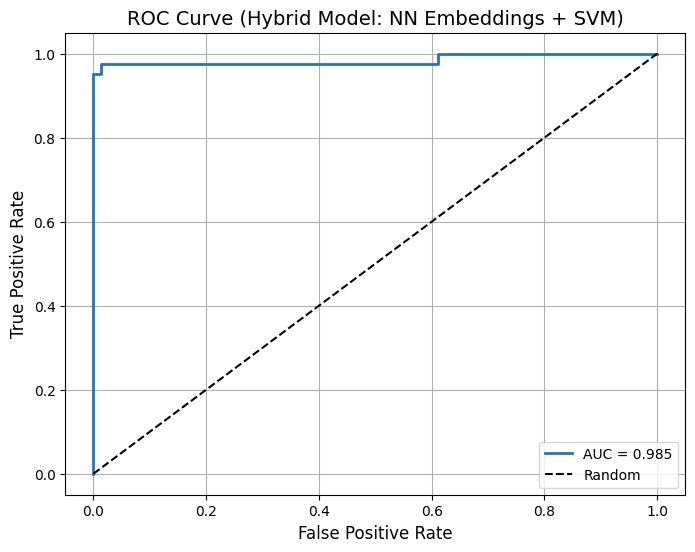

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# True labels (0/1)
y_true = y_test_numeric.values  # ensure numeric

# Probabilities predicted by SVM
y_scores = y_proba  # np array from SVM

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute AUC
auc_value = roc_auc_score(y_true, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_value:.3f}', linewidth=2)

# Diagonal line = random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (Hybrid Model: NN Embeddings + SVM)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Once the model identifies malignant cases, it rarely misclassifies any when varying the threshold.
The AUC is 0.98, the hybrid model is performing exceptionally well.

It is scalonated because the dataset is small

# 4. Function to use the hybrid model

In [37]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import numpy as np

def hybrid_nn_svm_cv(X, y, bottleneck_dim=8, epochs=100, lr=0.001, k=10):
    """
    Trains the hybrid model (Neural Network Bottleneck + SVM) using K-Fold CV.

    Parameters:
        X (numpy array or DataFrame): input features
        y (Series or array): labels (0/1)
        bottleneck_dim (int): size of latent representation
        epochs (int): NN training epochs
        lr (float): learning rate
        k (int): number of folds

    Returns:
        metrics_dict: dictionary with averaged metrics
        preds_all: predictions concatenated for all CV folds
    """

    # Convert y to numpy array
    y = np.array(y).astype(float)

    # Store metrics
    accuracies, f1s, recalls, aucs = [], [], [], []
    preds_all = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\n🔹 Fold {fold+1}/{k}")

        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # ---- TO TORCH TENSOR ----
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

        # ---- INIT MODEL ----
        model = BottleneckMLP(input_dim=X_train.shape[1], bottleneck_dim=bottleneck_dim)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # ---- TRAIN NN ----
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs, _ = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        # ---- EXTRACT EMBEDDINGS ----
        model.eval()
        with torch.no_grad():
            _, Z_train = model(X_train_tensor)
            _, Z_test = model(X_test_tensor)

        Z_train_np = Z_train.numpy()
        Z_test_np = Z_test.numpy()

        # ---- SVM TRAINING ----
        svm = SVC(kernel='rbf', C=10, gamma=1, probability=True)
        svm.fit(Z_train_np, y_train)

        # ---- PREDICTIONS ----
        y_pred = svm.predict(Z_test_np)
        y_proba = svm.predict_proba(Z_test_np)[:, 1]

        # ---- METRICS ----
        accuracies.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_proba))

        preds_all.append(y_pred)

    # ---- RETURN AVERAGED METRICS ----
    metrics_dict = {
        "accuracy": np.mean(accuracies),
        "f1": np.mean(f1s),
        "recall": np.mean(recalls),
        "auc": np.mean(aucs),
        "acc_std": np.std(accuracies),
        "f1_std": np.std(f1s),
        "recall_std": np.std(recalls),
        "auc_std": np.std(aucs)
    }

    return metrics_dict, np.concatenate(preds_all)


In [38]:
metrics, preds = hybrid_nn_svm_cv(X_train_scaled, y_train_numeric, bottleneck_dim=8, epochs=100, k=30)
print(metrics)


🔹 Fold 1/30

🔹 Fold 2/30

🔹 Fold 3/30

🔹 Fold 4/30

🔹 Fold 5/30

🔹 Fold 6/30

🔹 Fold 7/30

🔹 Fold 8/30

🔹 Fold 9/30

🔹 Fold 10/30

🔹 Fold 11/30

🔹 Fold 12/30

🔹 Fold 13/30

🔹 Fold 14/30

🔹 Fold 15/30

🔹 Fold 16/30

🔹 Fold 17/30

🔹 Fold 18/30

🔹 Fold 19/30

🔹 Fold 20/30

🔹 Fold 21/30

🔹 Fold 22/30

🔹 Fold 23/30

🔹 Fold 24/30

🔹 Fold 25/30

🔹 Fold 26/30

🔹 Fold 27/30

🔹 Fold 28/30

🔹 Fold 29/30

🔹 Fold 30/30
{'accuracy': np.float64(0.9650000000000001), 'f1': np.float64(0.9206358782829371), 'recall': np.float64(0.9187950937950938), 'auc': np.float64(0.9595905483405484), 'acc_std': np.float64(0.056104235002227644), 'f1_std': np.float64(0.18809182408558306), 'recall_std': np.float64(0.19366070596756152), 'auc_std': np.float64(0.10445590798445174)}
